In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import time


In [16]:
# Download VIX data
vix_data = yf.download('^VIX', start='2010-01-01', end='2025-02-05', interval='1d')

# Extract 'Close' prices and handle missing values
vix_close = vix_data['Close'].dropna().values

# Normalize the data
scaler = StandardScaler()
vix_scaled = scaler.fit_transform(vix_close.reshape(-1, 1)).flatten()

# Split into training and validation sets
train_size = 0.8
train_length = int(len(vix_scaled) * train_size)
train_data = vix_scaled[:train_length]
val_data = vix_scaled[train_length:]


[*********************100%%**********************]  1 of 1 completed


In [23]:
def create_inout_sequences(input_data, input_window, output_window):
    inout_seq = []
    L = len(input_data)
    for i in range(L - (input_window + output_window) + 1):
        train_seq = input_data[i:i + input_window]  # Current input
        train_label = input_data[i + output_window:i + input_window + output_window]  # Target is offset
        inout_seq.append((train_seq, train_label))
    return torch.FloatTensor(np.array(inout_seq))


In [24]:
# Define sequence parameters
input_window = 100
output_window = 1

# Create sequences
train_sequence = create_inout_sequences(train_data, input_window, output_window)
val_sequence = create_inout_sequences(val_data, input_window, output_window)

# Move data to device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_sequence = train_sequence.to(device)
val_sequence = val_sequence.to(device)


In [25]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = 1 / (10000 ** ((2 * np.arange(d_model)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term[0::2])
        pe[:, 1::2] = torch.cos(position * div_term[1::2])
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :].repeat(1, x.shape[1], 1)

class TransAm(nn.Module):
    def __init__(self, feature_size=512, num_layers=2, dropout=0.2):
        super(TransAm, self).__init__()
        self.input_embedding = nn.Linear(1, feature_size)
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=8, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(feature_size, 1)

    def forward(self, src):
        src = self.input_embedding(src)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = self.decoder(output)
        return output


In [26]:
def get_batch(input_data, i, batch_size):
    batch_len = min(batch_size, len(input_data) - i)
    data = input_data[i:i + batch_len]
    input = torch.stack([item[0] for item in data]).view(input_window, batch_len, 1)
    target = torch.stack([item[1] for item in data]).view(input_window, batch_len, 1)
    return input, target

def evaluate(eval_model, data_source):
    eval_model.eval()
    total_loss = 0.
    with torch.no_grad():
        for i in range(0, len(data_source), batch_size):
            data, targets = get_batch(data_source, i, batch_size)
            output = eval_model(data)
            total_loss += criterion(output, targets).cpu().item()
    return total_loss / len(data_source)


In [28]:
# Initialize model, optimizer, and loss function
model = TransAm().to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.00005, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5, verbose=True)

batch_size = 32
epochs = 25
train_losses, val_losses = [], []

# Training loop
for epoch in range(1, epochs + 1):
    model.train()
    epoch_loss = 0
    for i in range(0, len(train_sequence), batch_size):
        data, targets = get_batch(train_sequence, i, batch_size)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    train_losses.append(epoch_loss / len(train_sequence))

    # Validation step
    val_loss = evaluate(model, val_sequence)
    val_losses.append(val_loss)

    scheduler.step(val_loss)
    print(f'Epoch {epoch}/{epochs}, Train Loss: {train_losses[-1]:.5f}, Val Loss: {val_losses[-1]:.5f}')


Epoch 1/5, Train Loss: 0.03333, Val Loss: 0.00272
Epoch 2/5, Train Loss: 0.00803, Val Loss: 0.00400
Epoch 3/5, Train Loss: 0.01055, Val Loss: 0.00211
Epoch 4/5, Train Loss: 0.01450, Val Loss: 0.00257
Epoch 5/5, Train Loss: 0.00580, Val Loss: 0.00253


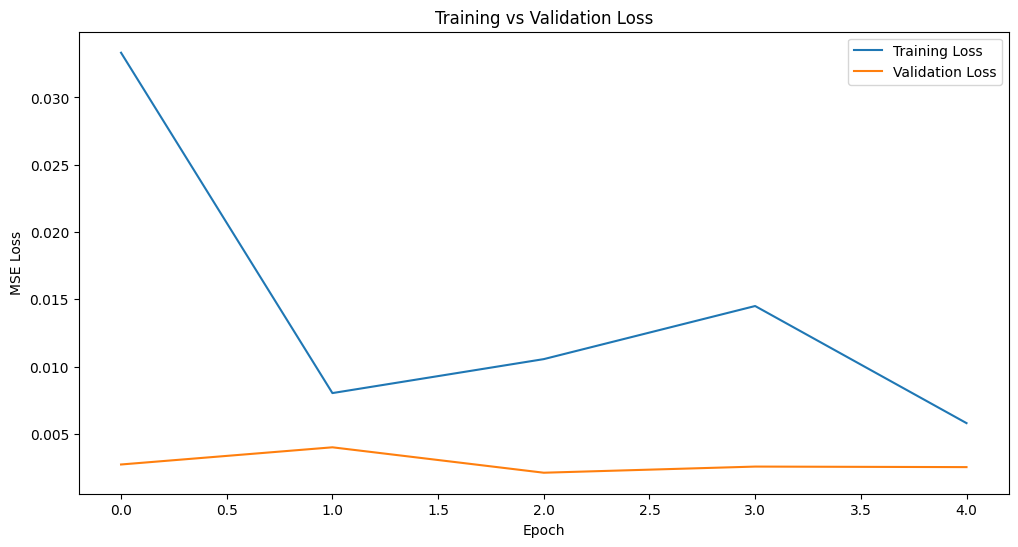

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()


In [30]:
def predict_vix(model, data_sequence):
    model.eval()
    predictions = torch.Tensor(0).to(device)

    with torch.no_grad():
        for i in range(len(data_sequence) - input_window):  # No need to leave a gap at the end
            data, _ = get_batch(data_sequence, i, 1)
            output = model(data)
            predictions = torch.cat((predictions, output[-1].view(-1)))

    return predictions.cpu().numpy()


# Predict on train and test sets
train_pred = predict_vix(model, train_sequence)
test_pred = predict_vix(model, val_sequence)



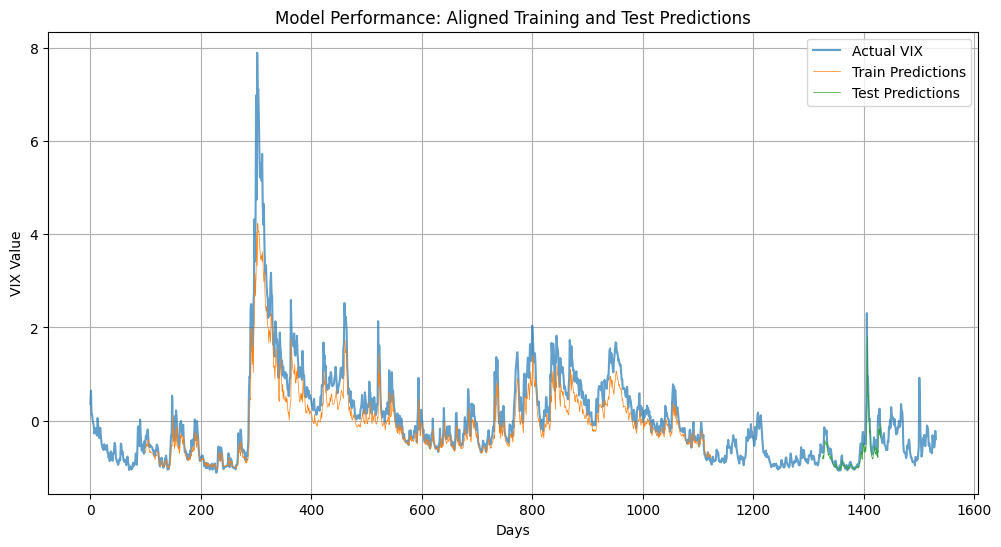

In [38]:
# Get the length of the training sequence (offset due to input window)
train_seq_offset = input_window

# Get the length of the validation data after the training window
val_seq_offset = train_length + input_window

plt.figure(figsize=(12, 6))

# Plot the actual VIX data
plt.plot(vix_scaled, label='Actual VIX', alpha=0.7)

# Adjust the indices to align predictions correctly
plt.plot(range(train_seq_offset, train_seq_offset + len(train_pred)), train_pred, label='Train Predictions', linewidth=0.5)

# Ensure test predictions are plotted right after the training period
plt.plot(range(val_seq_offset, val_seq_offset + len(test_pred)), test_pred, label='Test Predictions', linewidth=0.5)

plt.title('Model Performance: Aligned Training and Test Predictions')
plt.xlabel('Days')
plt.ylabel('VIX Value')
plt.legend()
plt.grid(True)
plt.show()


In [47]:
from sklearn.metrics import mean_absolute_error, r2_score

# Print diagnostics
print(f"Total train actual length: {len(train_actual)}, Total test actual length: {len(test_actual)}")
print(f"Train prediction length: {len(train_pred)}, Test prediction length: {len(test_pred)}")
print(f"Train offset: {train_offset}, Test offset: {test_offset}")

# Offset setup
train_offset = input_window
test_offset = min(train_length, len(test_actual) - len(test_pred))  # Adjust test offset to fit within available data

# Ensure the test offset doesn't exceed available data
if test_offset < 0:
    print("Test offset exceeds available data! Reducing offset to 0.")
    test_offset = 0

# Align training data
train_actual_aligned = train_actual[train_offset:train_offset + len(train_pred)]

# Align test data
test_actual_aligned = test_actual[test_offset:test_offset + len(test_pred)]

# Handle potential alignment issues
print(f"Aligned train actual length: {len(train_actual_aligned)}, train predicted length: {len(train_pred)}")
print(f"Aligned test actual length: {len(test_actual_aligned)}, test predicted length: {len(test_pred)}")

# Check for length mismatches
if len(train_actual_aligned) == len(train_pred) and len(test_actual_aligned) == len(test_pred):
    # Calculate metrics
    train_mae = mean_absolute_error(train_actual_aligned, train_pred)
    train_r2 = r2_score(train_actual_aligned, train_pred)

    test_mae = mean_absolute_error(test_actual_aligned, test_pred)
    test_r2 = r2_score(test_actual_aligned, test_pred)

    # Print results
    print(f"Training MAE: {train_mae:.2f}, R²: {train_r2:.2f}")
    print(f"Test MAE: {test_mae:.2f}, R²: {test_r2:.2f}")
else:
    print("Mismatch in actual and predicted lengths after alignment! Please check offsets and data consistency.")


Total train actual length: 1225, Total test actual length: 307
Train prediction length: 1025, Test prediction length: 107
Train offset: 100, Test offset: 200
Aligned train actual length: 1025, train predicted length: 1025
Aligned test actual length: 107, test predicted length: 107
Training MAE: 22.72, R²: -7.02
Test MAE: 18.08, R²: -43.66
